In [1]:
import os
import xarray as xr
import pandas as pd
import dask
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from dask_jobqueue import PBSCluster
from dask.distributed import Client
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point
import copy
import functools
import glob
import scipy

In [2]:
def get_surdat(surdat_file):
    """
    Read in CLM surface data file and pull out needed values
    
    """

    surdat = xr.open_dataset(surdat_file)

    # set actual latitude and longitude values as the dimension values
    surdat['lat'] = xr.DataArray(np.unique(surdat.LATIXY.values), dims='lsmlat')
    surdat['lon'] = xr.DataArray(np.unique(surdat.LONGXY.values), dims='lsmlon')
    surdat = surdat.swap_dims({'lsmlat': 'lat', 'lsmlon': 'lon'})

    surdat['PCT_NAT_PFT_UPDATED'] = (surdat.PCT_NAT_PFT*(surdat.PCT_NATVEG/100.0))
    surdat['PCT_CFT_UPDATED'] = (surdat.PCT_CFT*(surdat.PCT_CROP/100.0))

    out = surdat[['PCT_NAT_PFT_UPDATED', 'PCT_CFT_UPDATED']]

    lat = out.lat.data
    lon = out.lon.data
    out['dominant_pft_ind'] = xr.DataArray(
        data=999,
        dims=["lat", "lon"],
        coords=dict(
            lon=(["lon"], lon),
            lat=(["lat"], lat),
        )
    )
    out['dominant_pft'] = xr.DataArray(
        data='-'*500,
        dims=["lat", "lon"],
        coords=dict(
            lon=(["lon"], lon),
            lat=(["lat"], lat),
        )
    )

    return out

In [3]:
def get_dom_pfts(dat,threshold):
    all_pfts = np.append(dat.PCT_NAT_PFT_UPDATED.values, dat.PCT_CFT_UPDATED.values)
    non_veg = all_pfts[0]
    
    veg = all_pfts[1:]
    
    if (all_pfts.sum() >= threshold) & (non_veg <= 50):

            sum_veg = veg.sum()
            veg_prop = (veg/sum_veg)*100.0
            
            sorted_pfts = sorted(veg_prop, reverse=True)
            pft_sort = np.flip(np.argsort(veg_prop))
            
            if sorted_pfts[0] >= threshold:
                dom_pft_inds = [pft_sort[0].tolist()]
            else:
                cumul_prop = sorted_pfts[0]
                for i in range(1, len(sorted_pfts)):
                    cumul_prop = cumul_prop + sorted_pfts[i]
                    if cumul_prop >= threshold:
                        dom_pft_inds = pft_sort[:i+1].tolist()
                        break
            
            clm_pft_ind = [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16]
            dom_pfts = [clm_pft_ind[i] for i in sorted(dom_pft_inds)]

    else:
        if non_veg >= threshold:
            dom_pfts = [0]
        else:
            dom_pfts = '-'
        
    return dom_pfts

### Setup

In [4]:
## Surface datasets
surdat_dir = "/glade/p/cesmdata/cseg/inputdata/lnd/clm2/surfdata_map/"
surdat_2deg = os.path.join(surdat_dir, "release-clm5.0.18", "surfdata_1.9x2.5_hist_16pfts_Irrig_CMIP6_simyr2000_c190304.nc")
surfdat = get_surdat(surdat_2deg)

In [5]:
filename = '/glade/derecho/scratch/linnia/BNF_v2.n01_ctsm5.3.012_transient_SP_0/run/BNF_v2.n01_ctsm5.3.012_transient_SP_0.clm2.h1.2000-02-01-00000.nc'
ds_sp = xr.open_dataset(filename)
landfrac = ds_sp.landfrac

In [6]:
veg_combos = {
    "Boreal shrubland": {tuple([12])},
    "Tundra": {tuple([11]),tuple(sorted([11, 12]))},
    "Boreal forest": {tuple([2]),tuple(sorted([2,11, 12])),tuple(sorted([2, 12])),tuple(sorted([2, 11]))},
    "Siberian larch" : {tuple(sorted([3])),tuple(sorted([11,3])),tuple(sorted([12,3])),tuple(sorted([11,12,3]))},
    
    "Tropical rainforest" : {tuple(sorted([4]))},
    "Tropical savanna": {tuple(sorted([4,14])),tuple(sorted([14]))},
    "Subtropical savanna" : {tuple(sorted([6,14])),tuple(sorted([4,6])),tuple(sorted([4,6,14]))},

    "Grasslands" : {tuple(sorted([13])),tuple(sorted([13,15])),tuple(sorted([13,14])),tuple(sorted([13,14,15]))},
    "Shrubland" :  {tuple(sorted([10,13])),tuple(sorted([10,14])),tuple(sorted([10,13,14])),tuple(sorted([10,13,15])),tuple(sorted([10,14,15])),tuple(sorted([10,13,14,15]))},
    
    
    "Mixed deciduous temperate forest" :  {tuple(sorted([7])),
                                           tuple(sorted([1,7])),
                                           tuple(sorted([7,13])),
                                           tuple(sorted([7,14])),
                                           tuple(sorted([7,15])),
                                           tuple(sorted([1,7,13])),
                                           tuple(sorted([1,7,14])),
                                           tuple(sorted([1,7,15])),
                                           tuple(sorted([1,7,13,15])),
                                           tuple(sorted([1,7,14,15])),
                                           tuple(sorted([1,7,13,14])),
                                           tuple(sorted([7,13,14])),
                                           tuple(sorted([7,13,15])),
                                           tuple(sorted([7,14,15])),
                                           tuple(sorted([7,13,14,15])),
                                           tuple(sorted([1,7,13,14,15]))},

    "Conifer forest" : {tuple(sorted([1])),
                        tuple(sorted([1,2])),
                        tuple(sorted([1,13])),
                        tuple(sorted([1,14])),
                        tuple(sorted([1,15])),
                        tuple(sorted([1,2,13])),
                        tuple(sorted([1,2,14])),
                        tuple(sorted([1,2,15])),
                        tuple(sorted([1,13,14])),
                        tuple(sorted([1,13,15])),
                        tuple(sorted([1,14,15])),
                        tuple(sorted([1,2,13,14])),
                        tuple(sorted([1,2,13,15])),
                        tuple(sorted([1,2,14,15])),
                        tuple(sorted([1,13,14,15])),
                        tuple(sorted([1,2,13,14,15]))},
    "Broadleaf deciduous boreal trees" : { tuple(sorted([8])),
               tuple(sorted([2,8])),
               tuple(sorted([8,12])),
               tuple(sorted([8,13])),
               tuple(sorted([8,15])),
               tuple(sorted([2,8,12])),
               tuple(sorted([2,8,13])),
               tuple(sorted([2,8,15])),
               tuple(sorted([8,12,13])),
               tuple(sorted([8,12,15])),
               tuple(sorted([8,13,15])),
               tuple(sorted([2,8,13,15])),
               tuple(sorted([2,8,12,13])),
               tuple(sorted([2,8,12,15])),
               tuple(sorted([2,8,12,13,15])),
              },

    "Broadleaf evergreen temperate tree" : {tuple(sorted([5])),
                    tuple(sorted([5,13])),
                    tuple(sorted([5,14])),
                    tuple(sorted([5,15])),
                    tuple(sorted([5,13,14])),
                    tuple(sorted([5,13,15])),
                    tuple(sorted([5,14,15])),
                    tuple(sorted([5,13,14,15]))}

}


### Create biome masks

In [7]:
# Find PFTs that sum to > 80% of vegetated portion of gridcell
threshold=80

lats = surfdat.lat.values
lons = surfdat.lon.values

dom_pft_data = np.empty((len(lats), len(lons)), dtype=object)

for i, lat in enumerate(lats):
    for j, lon in enumerate(lons):
        if landfrac.sel(lat=lat,method='nearest').sel(lon=lon,method='nearest')>0.25:
            dat = surfdat.sel(lat=lat, method='nearest').sel(lon=lon, method='nearest')
            dom_pft_data[i, j] = get_dom_pfts(dat, threshold)

# Store in an xarray Dataset
ds_out = xr.Dataset(
    {
        "dom_pfts": (["lat", "lon"], dom_pft_data)
    },
    coords={
        "lat": lats,
        "lon": lons
    }
)


In [8]:
# create dataset of 2D biome masks
biome_masks = {}

lat_values = ds_out.lat.values
lon_values = ds_out.lon.values

for biome_name, pft_combos in veg_combos.items():
    # Create a binary mask for the biome
    biome_mask = np.zeros((len(lat_values), len(lon_values)), dtype=int)  

    for i, lat in enumerate(lat_values):
        for j, lon in enumerate(lon_values):
            dom_pfts = ds_out.dom_pfts.values[i, j] 
            
            if dom_pfts is not None:
                sorted_pfts = tuple(sorted(dom_pfts))  
                if sorted_pfts in pft_combos:
                    biome_mask[i, j] = 1  # Mark as 1 (true)

    # Store the mask in the dictionary
    biome_masks[biome_name] = (["lat", "lon"], biome_mask)


biome_ds = xr.Dataset(biome_masks, coords={"lat": lat_values, "lon": lon_values})


In [11]:

biome_names = ['Tropical rainforest','Tropical savanna','Subtropical savanna','Broadleaf evergreen temperate tree','Grasslands','Shrubland',
               'Mixed deciduous temperate forest','Conifer forest','Siberian larch','Boreal forest','Broadleaf deciduous boreal trees','Boreal shrubland','Tundra']

# Create an empty array for the final categorical map
lat_values = biome_ds.lat.values
lon_values = biome_ds.lon.values
biome_map = np.zeros((len(lat_values), len(lon_values)))  # Default to 0 (background)

# Assign unique values to each biome
for idx, biome in enumerate(biome_names, start=1):
    biome_mask = biome_ds[biome].values
    biome_map[biome_mask == 1] = idx  # Assign unique integer value


In [17]:
# use whittaker biomes file as template
wfile='/glade/u/home/djk2120/ctsm6_ppe/biomes/whit/whitkey.nc'
whit=xr.open_dataset(wfile)

In [18]:
biome_names = ['Other','Tropical rainforest','Tropical savanna','Subtropical savanna','Broadleaf evergreen temperate tree','Grasslands','Shrubland',
               'Mixed deciduous temperate forest','Conifer forest','Siberian larch','Boreal forest','Broadleaf deciduous boreal trees','Boreal shrubland','Tundra']

ds_biome_maps = whit.copy()
ds_biome_maps['sudoku_biomes'] = (('lat', 'lon'), biome_map)
ds_biome_maps = ds_biome_maps.assign_coords(biome_names=biome_names)
ds_biome_maps = ds_biome_maps.drop_vars('biome_fg')
ds_biome_maps = ds_biome_maps.drop_vars('biome_name')

In [26]:
ds_biome_maps.attrs['script'] = '/glade/u/home/linnia/ctsm6_ppe/biomes/create_biome_masks.ipynb'
del ds_biome_maps.attrs['climo']
del ds_biome_maps.attrs['case']

In [35]:
ds_biome_maps.to_netcdf('sudoku_biomes.nc')

### Plot biome map

In [36]:
from matplotlib.colors import ListedColormap
colors = [
    "grey",
    "#004D19","#5D9945","darkseagreen","#E9DFC1",   # (tropic, tropic, savanna, eucalyptus)
    "#DECAA7", "#D2B48C", # (grasslands, shrublands)
    "#97A669","lightblue","teal",# (mixed decid, conifer, larch)
    "cadetblue","thistle","lavenderblush","lavender" # (boreal forest, aspen, boreal shrub, tundra)
    
]

cmap = ListedColormap(colors, name="earth_biomes_19")


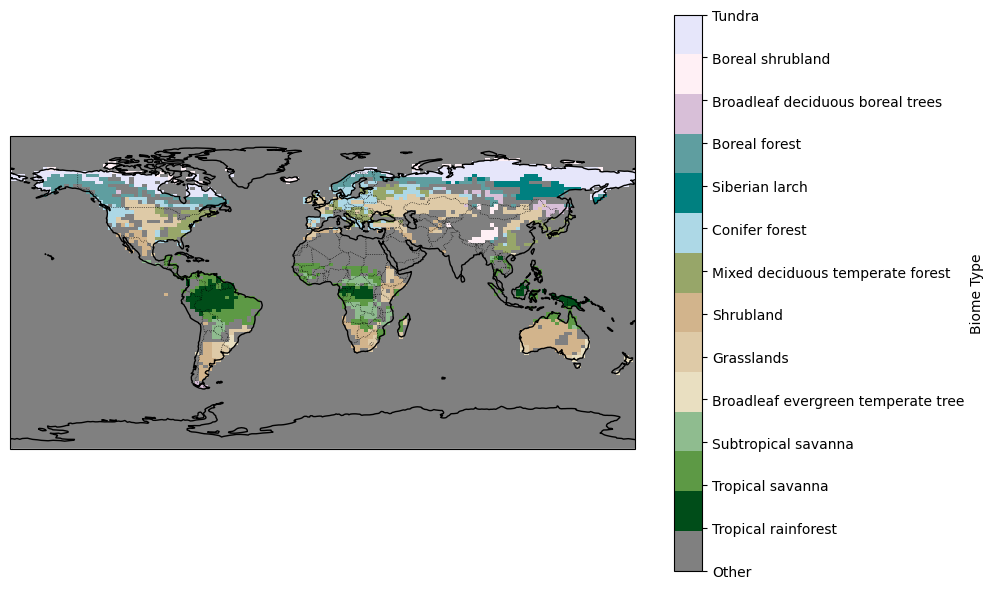

In [40]:
fig, ax = plt.subplots(figsize=(10, 6), subplot_kw={"projection": ccrs.PlateCarree()})
mesh = ax.pcolormesh(lon_values, lat_values, ds_biome_maps.sudoku_biomes, cmap=cmap, shading='auto')
ax.coastlines()
ax.add_feature(cfeature.BORDERS, linestyle=":", linewidth=0.5)

cbar = plt.colorbar(mesh,ticks=np.arange(0, len(biome_names) + 1))
cbar.set_label("Biome Type")
cbar.set_ticks(np.arange(0, len(biome_names)))
cbar.set_ticklabels(np.concatenate([np.array(biome_names)]))

plt.tight_layout()
plt.savefig('sudoku_biome_map.png')